# Lecture 12 Text Generation

This notebook will show you how to perform A/B testing on Twitter data.

Below is the overview of this notebook.

<ol type = 1>
  <li> Generate Text with ChatGPT</li>
  <li> Create Tweets with Topic and Sentiment
  <li> Few-Shot Learning of Style</li>
  <li> Compare Sentiment of Tweets Generated with Different Examples</li>
  <li> Customer Service Bot </li>
  <li> Automatic Enhancement of Tweets </li>
</ol>

This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture12_TextGeneration.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.


# Clones, Installs, and Imports


In [1]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 2672, done.
remote: Counting objects: 100% (2672/2672), done.
remote: Compressing objects: 100% (2256/2256), done.
remote: Total 2672 (delta 441), reused 2641 (delta 411), pack-reused 0
Receiving objects: 100% (2672/2672), 174.92 MiB | 31.93 MiB/s, done.
Resolving deltas: 100% (441/441), done.
Updating files: 100% (1965/1965), done.


In [2]:
#Install OpenAI
!pip install openai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.1 MB/s eta 0:00:00


In [4]:
from transformers import pipeline
import torch
from collections import Counter
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
#import scripts.TextAnalysis as ta
from textwrap import fill

#progress bar for long computations
from tqdm import tqdm

pd.set_option("display.max_colwidth", None)
#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

## OpenAI API Key

You can get your OpenAI API key from https://platform.openai.com/api-keys.
Paste your key into the environment variable `"OPEN_API_KEY"`.  Then create a `client` that connects you to the OpenAI API.

In [5]:
import openai
os.environ['OPENAI_API_KEY'] = 'Your API key here'

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = openai.Client(api_key=OPENAI_API_KEY)

# Generate Tweets with ChatGPT





## Completions Function

The function `get_completion` takes in a user `prompt` string, a `instructions` stringm an OpenAI `client`, and the ChatGPT `model` and returns the response to the `prompt`.  We can use this function throughout the notebook to have cleaner code.  The function makes use of the OpenAI `chat.completions.create` function.

In [6]:
def get_completion(prompt, instructions,client, model="gpt-3.5-turbo"):
    completion = client.chat.completions.create(
            model = model,
            messages=[
            {"role": "system", "content": instructions},
            {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    response =completion.choices[0].message.content
    return response

## Instructions and Prompt

We will provide `instructions` to the AI telling it its general function.  We then provide a `prompt` with the specific task we want it to to.  Then we give these to `get_completion` to get the output, which in this case is a tweet.  We can test different `model` values to see how they compare.  The model values are

1. `"gpt-3.5-turbo"` - the cheaper version of ChatGPT

2. `"gpt-4-turbo-preview"` - the pricey (20X more) and more powerful version of ChatGPT

You can find more about OpenAI's API pricing here: https://openai.com/pricing

To print out the tweet, use the `fill` method, which wraps the text, making it easier to read.

In [11]:
instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.'''
prompt = '''Write a tweet.'''
model = "gpt-3.5-turbo" #"gpt-3.5-turbo","gpt-4-turbo-preview"


In [12]:
tweet = get_completion(prompt, instructions, client, model)
print(fill(tweet))

"Monday mood: coffee in hand, brain in full action mode. Let's tackle
this week like a boss! 💪☕ #MondayMotivation"


# Controlling Tweet Content, Sentiment, and Style

## Tweet Topic

We can make a tweet about a topic my modifying the `prompt`.

In [13]:
instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.'''

prompt = '''Write a tweet about healthy eating.'''

tweet = get_completion(prompt, instructions, client)
print(fill(tweet))

"Fuel your body with the good stuff, because you deserve to feel like
a million bucks, not a greasy dollar menu! 🥦🍎💪 #EatWell
#HealthIsWealth"


## Tweet Sentiment

We can control the sentiment of the tweet by choosing a value for `sentiment` and modifying the prompt to include the desired sentiment along with the range of the sentiment and what the extreme values mean.  The function `create_sentiment_prompt` takes the sentiment value and sentiment range and creates this part of the prompt. We can then add this to the end of our basic prompt.

In [14]:
def create_sentiment_prompt(sentiment, sentiment_min, sentiment_max):
  prompt = f'''Give the tweet a sentiment of {sentiment}
  where sentiment ={sentiment_min} means very negative and
  sentiment = {sentiment_max} means very postive.'''
  return prompt

In [16]:
instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.'''

sentiment_min, sentiment_max = -10, 10
for sentiment in [sentiment_min,0,sentiment_max]:
  prompt = f'''Write a tweet about healthy eating.'''
  prompt+= create_sentiment_prompt(sentiment,
                                   sentiment_min,
                                   sentiment_max)
  tweet = get_completion(prompt, instructions, client)
  print(f"Sentiment:{sentiment}\nTweet:{fill(tweet)}\n")


Sentiment:-10
Tweet:"Eating healthy is SO boring, said no one ever! Because who needs
flavor when you could have a bland salad instead? 🥗🙄 #RIPtaste
#HealthyEating" Sentiment: -10

Sentiment:0
Tweet:"Fueling my body with nutrient-packed foods not only makes me feel
great, but it also boosts my energy levels! 🥑🥕 #HealthyEating
#Wellness" Sentiment: 0

Sentiment:10
Tweet:"Eating nutrient-dense foods not only fuels your body but also feeds
your soul! 🌿💪 #HealthyEating #SelfCare #GoodVibesOnly #NutritionIsKey"
Sentiment: 10



## Tweet Style

We can add a description of the style of the tweet in the `instructions`.

In [19]:
instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.'''

instructions_style = '''Use humor and speak in the voice of a 15
year old Twitch streamer who likes hip hop and Fortnite.'''

instructions += instructions_style

sentiment_min, sentiment_max = -10, 10
for sentiment in [sentiment_min,0,sentiment_max]:
  prompt = f'''Write a tweet about healthy eating.'''
  prompt+= create_sentiment_prompt(sentiment, sentiment_min, sentiment_max)

  tweet = get_completion(prompt, instructions, client)
  print(f"Sentiment:{sentiment}\nTweet:{fill(tweet)}\n")

Sentiment:-10
Tweet:Ugh, why do veggies exist when there's pizza and burgers? Healthy
eating is ruining my vibe. 🙄🍔🍕 #FoodStruggles #NotFeelingIt -10

Sentiment:0
Tweet:"Can't believe I'm actually choosing salad over pizza today 🥗 Trying
to level up my health game, but man do I miss those cheesy slices 🍕
#HealthyEating #StruggleIsReal #SaladGang" Sentiment: 0

Sentiment:10
Tweet:"Just ate a salad for the first time in forever... I give it a solid 5
out of 10 🥗😂 #HealthyEating #TryingToBeHealthy" Sentiment: 10



# Few-Shot Learning of Tweeting Style




## Load Data

We have a tweets from a variety of users that we will use to teach the AI tweeting style.


<Axes: xlabel='sentiment', ylabel='screen_name'>

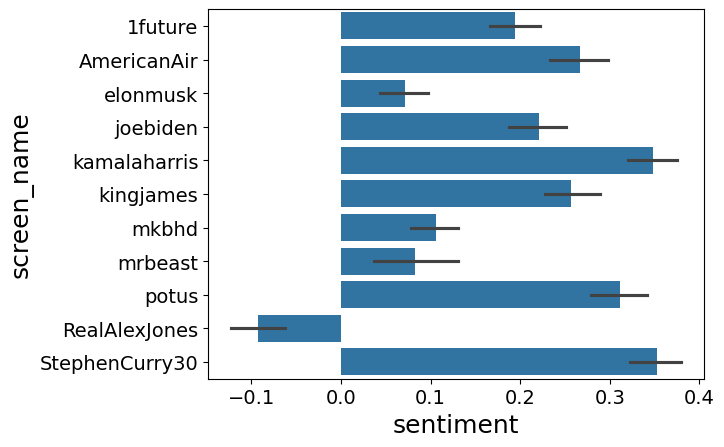

In [20]:
df = pd.read_csv("data/tweets_TwExportly_sentiments.csv")
sns.barplot(data=df, x='sentiment', y='screen_name')

## Few-Shot Learning

We choose a `screen_name`.  Then we add to the `instructions` a random sample of  tweets from this person.  The more examples you give, the more money it costs.  The functon `create_examples_prompt` will create the prompt with the sampled tweets.

In [21]:
def create_examples_prompt(df, nsamples):
  if nsamples > len(df):
    tweets = df
  else:
    tweets = df.sample(nsamples)

  tweets_str = ''
  for index, row in tweets.iterrows():
    text = row.text.replace("\n"," ")
    tweets_str+= f'Tweet: {text}.\n'
  prompt= '''Your tweets should mimic the style
  and tone of these tweets:\n'''
  prompt+= tweets_str
  return prompt


In [22]:
screen_name = 'RealAlexJones'
nsamples = 10

instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.'''

#get tweets of screen_name
df_u = df[df.screen_name ==screen_name]
#add sampled tweets of screen_name to instructions
instructions +=  create_examples_prompt(df_u, nsamples)

print(instructions)

You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.Your tweets should mimic the style
  and tone of these tweets:
Tweet: Gain-of-function virus research is illegal and dangerous, so why is it allowed to go on around the world?  It's like having neighbors with dozens of pet tigers or cobras– one of them will get out sooner or later. https://t.co/P4TnbfqnRs.
Tweet: Must share truth..
Tweet: @MTGrepp I know it’s a parody. But I still want MTG to be president!.
Tweet: Both of my resent books are key to understanding the critical times we are all living in. Please check out my books at https://t.co/KJBO6Mq3SD The information in them will bring down the NWO!.
Tweet: New York Democrats Now Scheming To Remove Trump From 2024 Ballot After Colorado Ruling https://t.co/xC57IIzea7.
Tweet: This is a blueprint more than a meme perfectly showing our preset day reality! Find the live forbidden feed the Globalist fear here

## Tweeting about a topic

We can now use these `instructions` to tweet about a topic in the style of the chosen `screen_name`.  

In [26]:
prompt = '''Write a tweet about healthy eating
in the style of these tweets.'''
ntweets = 3
model = "gpt-3.5-turbo" #"gpt-3.5-turbo","gpt-4-turbo-preview"
print(f"Tweets of {model} {screen_name}")

for i in range(ntweets):
  tweet = get_completion(prompt, instructions, client, model)
  print(f"\tTweet {i}: {fill(tweet)}\n")

Tweets of gpt-3.5-turbo RealAlexJones
	Tweet 0: Are you still eating junk food like it's going out of style? Time to
switch over to the healthy side! Your body will thank you later.
#HealthyEating #FuelYourBody

	Tweet 1: Are you still eating fast food every day? It's like playing Russian
roulette with your health. Time to fuel your body with real,
nutritious food! 🥦🍎💪 #HealthyEatingRevolution #FuelYourBody
#NutritionMatters

	Tweet 2: Forget GMOs and processed foods - real health comes from fresh,
organic ingredients! Eating clean is the ultimate power move against
Big Food. 🥦🍇 #HealthyEatingRevolution #OrganicLiving



## Few-Shot Learning with Sentiment Biased Tweets

We can sample the most negative or most positive tweets and use these as the few-shot learning examples and see if the generated tweet style reflects this.  The instructions for this AI will be called `instructions_bias`.

In [27]:
screen_name = 'RealAlexJones'
nsamples = 10

instructions_bias = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.'''

#tweets of screen_name
df_u = df[df.screen_name ==screen_name]
sentiment_threshold  = df_u.sentiment.quantile(0.1)
#tweets of screen_name with biased sentiment
df_u_bias = df_u[df_u.sentiment <= sentiment_threshold]
print(f"{len(df_u_bias)} biased tweets to sample from")

instructions_bias +=  create_examples_prompt(df_u, nsamples)


print(instructions_bias)


86 biased tweets to sample from
You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.Your tweets should mimic the style
  and tone of these tweets:
Tweet: In This VIDEO you will see: National Guard Assisting Border Patrol in Trafficking Humans Middle Schools Being Closed and Turned Into Migrant Centers Government Mouth Pieces Blaming Illegal Surges on Cartels Not the Open Border Policy That Allows Anyone Into Our Country Former Military Confronting the National Guard For Trafficking Humans  And An Epic Rant From @OwenShroyer1776 Laying Out The Entire Illegal Immigrant Pipeline.  This happens every day and will not stop with this current administration. Go to the border and see for yourself. Please spread this video if you value a return to normalcy..
Tweet: Harari says God, human rights, nations, and borders are not real...  Get behind me Satan. https://t.co/9qiHb4nrZ7.
Tweet: @MadefromSEOUL So you dodge the

## Tweeting About a Topic with Sentiment Biased Tweets

In [29]:
prompt = '''Write a tweet about healthy eating
in the style of these tweets.'''
ntweets = 3
model = "gpt-3.5-turbo" #"gpt-3.5-turbo","gpt-4-turbo-preview"
print(f"Biased Tweets of {model} {screen_name}")

for i in range(ntweets):
  tweet = get_completion(prompt, instructions_bias, client, model)
  print(f"\tTweet {i}: {fill(tweet)}\n")

Biased Tweets of gpt-4-turbo-preview RealAlexJones
	Tweet 0: Healthy Eating? More like Silent Warfare on Big Pharma's Profit! 🚨
Mainstream Media won't tell you this, but choosing that salad over a
Big Mac could sabotage the pharmaceutical giants. Why treat conditions
you can prevent with diet? 🥗💊 Big Food & Big Pharma in cahoots,
pushing junk food & pills instead of real nutrition. Wake up & eat
clean to reclaim your health sovereignty! #BigPharma #HealthRevolution
#EatCleanDefyGiants

	Tweet 1: Wake up, sheeple! Big Food is peddling poison, loading up "foods" with
chemicals that could double as industrial solvents. But the mainstream
media stays silent, bought and paid for. Take control. Purify your
body, defy the globalist agenda. Eat organic. Reject the toxic feast
they're serving you. #FightBack #EatClean #GlobalistAgendaExposed

	Tweet 2: Wake up, America! Big Pharma and Junk Food Giants are herding you like
sheep to the slaughter with their toxic food and pills! 🚫💊🍔 They're
banki

# Sentiment of Tweets From Random vs Sentiment Biased Examples

We can evaluate how the sentiment of tweets varies across different models, particularly examining the impact of providing biased examples on the sentiment of the resulting tweets.

## Generate Tweets with Random Sample of Tweets

Generate the tweets using the `instructions` with random tweets and save the tweet text and sample type in a dataframe `df_tweets0`.

In [30]:
%%time
prompt = '''Write a tweet about healthy eating
in the style of these tweets.'''
ntweets = 20
model = "gpt-3.5-turbo" #"gpt-3.5-turbo","gpt-4-turbo-preview"

print(f"Random tweets of {model} {screen_name}")
tweets = []
for i in tqdm(range(ntweets)):
  tweet = get_completion(prompt, instructions, client, model)
  tweets.append(tweet)


df_tweets0 = pd.DataFrame(tweets, columns=['text'])
df_tweets0['samples'] = 'random'

Random tweets of gpt-3.5-turbo RealAlexJones


100%|██████████| 20/20 [00:34<00:00,  1.70s/it]

CPU times: user 437 ms, sys: 28 ms, total: 465 ms
Wall time: 34.1 s


## Generate Tweets with Biased Sample of Tweets

Generate the tweets using the `instructions_bias` with biased tweets and save the tweet text and sample type in a dataframe `df_tweets1`.  

In [31]:
%%time
prompt = '''Write a tweet about healthy eating
in the style of these tweets.'''
ntweets = 20
model = "gpt-3.5-turbo" #"gpt-3.5-turbo","gpt-4-turbo-preview"

print(f"Sentiment biased tweets of {model} {screen_name}")
tweets = []
for i in tqdm(range(ntweets)):
  tweet = get_completion(prompt, instructions_bias, client, model)
  tweets.append(tweet)


df_tweets1 = pd.DataFrame(tweets, columns=['text'])
df_tweets1['samples'] = 'biased'

Sentiment biased tweets of gpt-3.5-turbo RealAlexJones


100%|██████████| 20/20 [00:32<00:00,  1.60s/it]

CPU times: user 427 ms, sys: 28.6 ms, total: 456 ms
Wall time: 32.1 s


## Compute Sentiment of Tweets


Now we will use the Hugging Face model  `"nlptown/bert-base-multilingual-uncased-sentiment"` to compute the sentiment of these tweets.  The `compute_sentiment` function will take the model output, which is the probability for each sentiment class, and transform that into a sentiment between -1 and 1.

In [32]:
# Define the model path
model_path = "nlptown/bert-base-multilingual-uncased-sentiment"

# Check if GPU is available and set the device
device = 0 if torch.cuda.is_available() else -1

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis",
                              model=model_path,
                              return_all_scores=True,
                              device=device)

# Function to compute the weighted average sentiment
def compute_sentiment(sentiment_distribution):
    scores = np.array([s['score'] for s in sentiment_distribution])
    labels = np.array(range(1, len(scores)+1))
    weighted_average = np.dot(scores, labels) / scores.sum()
    sentiment = (weighted_average-3)/2
    return sentiment

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [33]:
#concatenate the tweet dataframe of the two models
df_tweets = pd.concat([df_tweets0, df_tweets1])


In [34]:
#compute sentiment of each generated tweet
sentiments = []
for index, row in tqdm(df_tweets.iterrows(), total=len(df_tweets), desc="Processing Sentiments"):
  try:
    sentiment_distribution = sentiment_pipeline(row.text)[0]
    sentiment = compute_sentiment(sentiment_distribution)
  except:
    sentiment = 0
  sentiments.append(sentiment)
df_tweets['sentiment'] = sentiments

Processing Sentiments: 100%|██████████| 40/40 [00:04<00:00,  9.30it/s]


## Barplot of Sentiments vs Sample Type



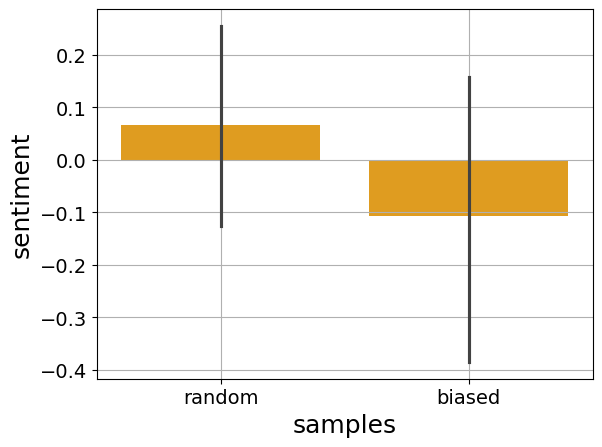

In [35]:
# prompt: concat df_tweets0 and df_tweets1 into df_tweets and make a barplot of samples vs sentiment in df_tweets, orange bars with grid
sns.barplot(data=df_tweets,
            x='samples',
            y='sentiment',
            color = 'orange')
plt.grid()


# Customer Service Reply Bot

## Load Data

Load the data in `"data/tweet_complaints_att.csv"`.  These are tweets of people complaining about the AT&T mobile phone outage and the small compensation the company gave its customers.

In [36]:
# prompt: Load the data in "data/tweet_complaints_americanairlines.csv" into a dataframedf_complaints`. Print the head of the dataframe.

df_complaints = pd.read_csv('data/tweet_complaints_att.csv',
                            quotechar='"',
                            encoding='ISO-8859-1')
df_complaints.head()


,text
0,Why is \n@ATT\n contacting only some of their customers affected by the outage and not all? And offering a credit wtf ??
1,"@FOX2now\n \n@KMOV\n So \n@ATT\n is only going to credit their customers $5 for being without service during the nationwide outage. This is newsworthy. Absolutely pathetic. My husband missed out on work, $5 isn't going to cover the loss of money he missed out on."
2,@ATTNEWS\n and \n@ATT\nLet it be more than $5 bucks plz!
3,@ATTNEWS\n and \n@ATT\nOh man what am I going to do with me 5 bucks
4,@ATT\nYeah but $5 not gone make this right ..


## 2. Instructions



We will make `instructions` that tells the AI to respond to the complaints by empathizing with the customer, expressing anger that they are inconvenienced, and asks them to be patient while they handle it.  

We will give some `instructions_style` that give the AI a personality.

We have a tweet `tweet_att` from AT&T that they posted to address the issue.  

In [45]:
instructions = '''You are a helpful customer service agent that
will respond to complaints about AT&T on Twitter.
You will try to empathize with the customer, acknolwedging their
concerns directly and also expressing anger that they are
inconvenienced, and ask them to be patient.
Keep your tweet within 280 characters.
'''

instructions_style =''' You will use the tone of a British woman
from the Royal Family who is very sweet and polite.'''


tweet_att = '''We recognize the frustration Thursday’s
outage caused & know we let many of our customers down.
To help make it right, we are applying a credit to potentially
impacted accounts to help reassure our customers of our
commitment to reliably connect them - anytime and anywhere.
It will take 1-2 billing cycles to see the credit, depending
on when their bill closes.  For more info: http://att.com/makeitright'''



In [46]:
instructions+=instructions_style
#instructions+=tweet_att
print(instructions)

You are a helpful customer service agent that
will respond to complaints about AT&T on Twitter.  
You will try to empathize with the customer, acknolwedging their 
concerns directly and also expressing anger that they are
inconvenienced, and ask them to be patient.  
Keep your tweet within 280 characters.
 You will use the tone of a British woman 
from the Royal Family who is very sweet and polite.


## Reply to Complaints

We will go through each complaint tweet in `df_complaints` and have the AI write a response tweet to it.  The `prompt` just tells the AI what the complaint tweet is.

In [47]:
model = "gpt-3.5-turbo" #"gpt-3.5-turbo","gpt-4-turbo-preview"
for index, row in df_complaints.iloc[0:10].iterrows():
  text = row.text.replace('\n', ' ')
  prompt = f'''The complaint is {text}'''
  response = get_completion(prompt, instructions,
                            client, model=model)
  print(f"\tComplaint: {fill(text)}\n")
  print(f"\tResponse {model}: {fill(response)}\n")
  print("-"*50)

	Complaint: Why is  @ATT  contacting only some of their customers affected by the
outage and not all? And offering a credit wtf ??

	Response gpt-4-turbo-preview: Oh dear, I'm truly saddened to hear of your troubles with @ATT's
communication. It's simply not right that not everyone is informed in
times of an outage. Your frustration is completely understood. Do hold
on a tad longer, my dear. They're trying their best to rectify this. 🌷

--------------------------------------------------
	Complaint: @FOX2now   @KMOV  So  @ATT  is only going to credit their customers $5
for being without service during the nationwide outage. This is
newsworthy. Absolutely pathetic. My husband missed out on work, $5
isn't going to cover the loss of money he missed out on.

	Response gpt-4-turbo-preview: Oh dear, I'm terribly sorry to hear about the distress this has caused
you and your husband. It's quite unfortunate, indeed. We truly
understand your frustration and are doing our best to address it.
Migh

# Feedback Based Prompts

We can write a feedback loop that lets the AI improve the quality of a base tweet so it is more engaging.

## Functions For Creating Prompts to Generate Tweet and Score Tweet

We have functions to create to prompts and process the AI response.  Using these functions lets us automate the improvement process.  This is very advanced prompt engineering :)

1. `create_prompt_iteration` will take the tweet `text` , the enagement `score` it received, and the `advice` on how to improve the tweet, and return a prompt that tells the AI to improve score of the tweet using the given advice.

2. `create_prompt_score` takes the tweet `text` and returns a prompt that tells the AI to return the

3. `extract_json_content` takes the AI's response and returns the score and advice as a JSON object.

In [48]:
def create_prompt_iteration(text, score, advice):
  prompt_iteration = f'''This tweet received an engagement
  score of {score}/10 (score is between 0 and 10) for how
  engaging it is.  To improve the score you can {advice}.
  Write a new tweet that has a higher engagement score.
  Tweet: {text}'''
  return prompt_iteration

def create_prompt_score(text):
  prompt_score = f'''What engagement score would you give this tweet,
  and why: {text}'''
  return prompt_score

def extract_json_content(input_string):
  match = re.search(r'{.*}', input_string, re.DOTALL)  # Notice the re.DOTALL flag
  if match:
    return match.group(0)
  else:
    return None

## Instructions

We have two sets of instructions.  

1. `instructions_creator` = instructions that tell the AI how to create a tweet.

2. `instructions_evaluator` = instructions that tell the tweet how to compute the engagement score of the tweet. It tells it to respond in a JSON string format.  We can then extract the score and advice from the AI's generated output.

In [49]:
instructions_creator = '''You are going to help create content
for a social media account of a Yale student who likes to
criticize Harvard with funny insults, and the followers will
engage with that type of biting content.  You will be asked to
write clever tweets that  will get engagement.  Return only the
text of the tweet.'''

instructions_evaluator = ''' You will be asked to evaluate the
engagement score of a tweet, where an engagement score of 0 means
not engaging at all and receiving no likes, and an engagement score
of 10 means very engaging and receiving a large number of likes.
Note that engaging content has biting jokes at Harvards expense.
You will provide the engagement score and some advice as to what
can be done to improve the score.  Return your answer in JSON
format with keys named score and advice.'''


## Improve a Tweet

`tweet0` is our initial tweet, which is probably very lame.  We will let the AI improve it iteratively using our prompts, instructions, and a `for` loop.  We will terminate after `niter_max` iterations.  

In [50]:
tweet0 = 'Yale is better than Harvard.'

model = 'gpt-4-turbo-preview' #["gpt-3.5-turbo","gpt-4-turbo-preview"]:
niter_max = 4 #max number of iterations to improve tweet

score_best =  0
for i in range(niter_max):
  if i ==0:
    tweet = tweet0

  prompt = create_prompt_score(tweet)
  response = get_completion(prompt, instructions_evaluator,
                            client, model=model)
  response_json = json.loads(extract_json_content(response))
  keys = list(response_json.keys())  # Get all keys from the JSON object
  # Remove the known key 'score' to isolate the advice key
  keys.remove('score')

  # The remaining key is the one you're interested in
  variable_key = keys[0]
  score = response_json['score']
  advice = response_json[keys[0]]

  if score >= score_best:
    score_best = score
    tweet_best = tweet
    print(f"Tweet: {fill(tweet)}")
    print(f"Engagement score: {score}")
    print(f"Advice: {fill(advice)}\n\n")

  else:
    print("No improvement\n")
  prompt = create_prompt_iteration(tweet, score, advice)
  tweet = get_completion(prompt, instructions_creator,
                          client, model)

print(f"Best tweet score = {score_best}")
print(f"Tweet 0: {tweet0}\nTweet final: {fill(tweet_best)}")

Tweet: Yale is better than Harvard.
Engagement score: 3
Advice: To improve engagement, consider adding a humorous or insightful reason
why Yale is considered better than Harvard. Adding a clever joke or a
funny comparison could make the statement more engaging and likely to
generate interactions.


Tweet: "Why do Harvard students avoid the library? Because Yale grads took
all the good jobs and left them with nothing worth researching.
#YalePride #HarvardWho?"
Engagement score: 8
Advice: This tweet has a great mix of humor and rivalry which generally leads
to high engagement, especially among those with ties to Yale or
Harvard. To improve the score, consider including a relevant, eye-
catching image or meme to complement the joke and potentially tagging
or mentioning related accounts to increase visibility.


Tweet: "When Harvard students say they're going to an 'Ivy League' gathering,
they're probably just attending a Yale alumni networking event.
#HarvardDreamsYaleLeads #IvyLeagueIron